<a href="https://colab.research.google.com/github/FatemeZamanian/DCGAN/blob/main/CelebaDataset/celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
!unzip -qq celeba-dataset.zip

In [ ]:
path='/content/img_align_celeba/img_align_celeba'
images=[]
for p in os.listdir(path)  [0:60000]:
  org=cv2.imread(os.path.join(path,p))
  org=cv2.resize(org,(64,64))
  org=cv2.cvtColor(org, cv2.COLOR_BGR2RGB)
  images.append(org)

len(images)

60000

In [ ]:
images=np.array(images)
train_images = images.reshape(images.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
generator_model = tf.keras.Sequential()
generator_model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Reshape((8, 8, 128)))
assert generator_model.output_shape == (None, 8, 8, 128)  # Note: None is the batch size

generator_model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 8, 8, 64)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 16, 16, 32)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator_model.output_shape == (None, 32, 32, 32)
generator_model.add(layers.BatchNormalization())
generator_model.add(layers.LeakyReLU())

generator_model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator_model.output_shape == (None, 64, 64, 3)

In [ ]:
discriminator_model= tf.keras.Sequential()
discriminator_model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[64, 64, 3]))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminator_model.add(layers.LeakyReLU())
discriminator_model.add(layers.Dropout(0.3))

discriminator_model.add(layers.Flatten())
discriminator_model.add(layers.Dense(1))

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 120
noise_dim = 100
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator_model,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow((np.array(predictions[i, :, :, :] * 127.5 ) + 127.5 ).astype('uint8'))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

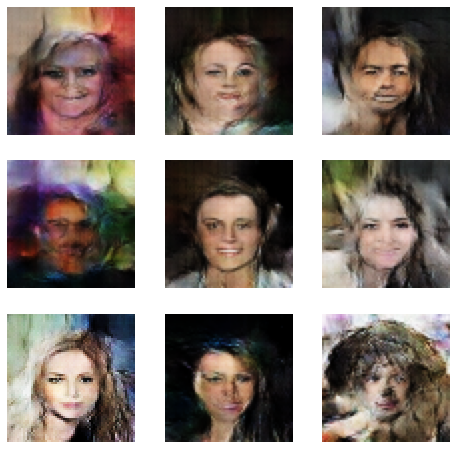

In [20]:
train(train_dataset, EPOCHS)

In [21]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [27]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)